In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.plotting import scatter_matrix
from sklearn import metrics
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SMOTENC, SVMSMOTE, KMeansSMOTE, ADASYN
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from data_processing import (identify_merger, clean_hcris_before_2010, clean_hcris_after_2010, imputation_method, resampling)
from grid_search import (grid_search_lr, grid_search_lda, grid_search_knn, grid_search_dt, grid_search_rf, grid_search_xgb)

In [2]:
# ignore warnings
warnings.filterwarnings("ignore")
# Set the display options
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
pd.options.mode.use_inf_as_na = True

# Data preparation

Firstly, I upload the verified data from Lina and identify the potential mergers (details see identify_merger() in data_processing.py).\
Return the data after identification as a dataframe (df1).\
Drop the 'Year of change' after 2012.

In [3]:
verified_data = identify_merger()
verified_data.drop(verified_data[verified_data['Year of change']==2017].index,inplace=True)
verified_data.drop(verified_data[verified_data['Year of change']==2016].index,inplace=True)
verified_data.drop(verified_data[verified_data['Year of change']==2015].index,inplace=True)
verified_data.drop(verified_data[verified_data['Year of change']==2014].index,inplace=True)
verified_data.drop(verified_data[verified_data['Year of change']==2013].index,inplace=True)

         id  Type of closure  \
0     10009              1.0   
1     10010              5.0   
2     10015              1.0   
3     10025              4.0   
4     10027              1.0   
..      ...              ...   
365  670018              1.0   
366  670021              4.0   
367  670029              5.0   
368  670052              4.0   
369  670066              4.0   

    Type of change (Convert/close/merge/change names)  Year of change  merged  
0                                               Close          2012.0       0  
1                                                Open             NaN       0  
2                                               Close          2011.0       0  
3                                         Open/merger          2013.0       1  
4                                               Close          2013.0       0  
..                                                ...             ...     ...  
365      Close, reopen in 2015 but probably partially  

Secondly, upload the unmatched hospital-level data obtained from Lina as another dataframe (df2).\
Drop the 'Year of change' after 2012.

In [4]:
hosp_data = pd.read_csv('hosp_closest_info_v5.csv', index_col=0, thousands=',')
print(f"The shape of original HCRIS 2012:{hosp_data.shape}")
# Match the column names with df1
hosp_data.rename(columns={'provider': 'id'}, inplace=True)
hosp_data.drop(hosp_data[hosp_data['year']==2017].index,inplace=True)
hosp_data.drop(hosp_data[hosp_data['year']==2016].index,inplace=True)
hosp_data.drop(hosp_data[hosp_data['year']==2015].index,inplace=True)
hosp_data.drop(hosp_data[hosp_data['year']==2014].index,inplace=True)
hosp_data.drop(hosp_data[hosp_data['year']==2013].index,inplace=True)

The shape of original HCRIS 2012:(103148, 123)


Merge two dataframes by hospital ids.

In [5]:
verified_hosp_data = pd.merge(verified_data, hosp_data, how='outer')
# Fill the value of column 'merged' in hosp_data not included in verified_data with 0
verified_hosp_data = verified_hosp_data.fillna({'merged':0})

# Data cleaning

Drop duplicates and keep the latest date information.

In [6]:
# Return DataFrame with duplicate rows removed except for the id with the recent date.
verified_hosp_data.drop_duplicates(subset=['id'], keep='last', inplace=True)
verified_hosp_data.sort_values(by='id', ascending=True, inplace = True)
verified_hosp_data.reset_index(drop=True, inplace = True)
print(verified_hosp_data.shape)
verified_hosp_data.head(20)

(7979, 127)


,id,Type of closure,Type of change (Convert/close/merge/change names),Year of change,merged,hrrnum,year,ssacounty,fips,zip_short.x,prvdr_num,fyb,fybstr,fye,fyestr,status,hospital_name,street_addr,po_box,city,state,zip_code,county,ime1,ime2,ime3,dsh1,dsh2,dsh3,dshpct,gme_part_a,gme_part_b,beds,bed_days,medicare_days,medicaid_days,days,intres,employees,volunteers,medicare_disch,medicaid_disch,discharges,medicaid_hmo_discharges,medicaid_hmo_ipf_subprovider,medicaid_hmo_irf_subprovider,medicaid_ipf_subprovider,medicaid_irf_subprovider,total_discharges_subprovider_ipf,total_discharges_subprovider_irf,overall,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,num_complete_survey,survey_response_rate,Hospital.Type,Hospital.Ownership,ehr,rate.x,mortality,safety,readmin,patient_exp,effective,timely,efficient_img,age,sex,race.x,race.y,buyin_mo,type_adm.x,type_adm.y,type_adm,ownership,ind_dsh,ind_teaching,efficiency,utilization,hsanum,prop_discharges,rate.y,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,ind_close,state_cd,id_closed,zip_short.y,year_close_combined,dist,ind_nearest,ind_after_1,ind_after_2,ind_after_3,ind_after_4,ind_after_5,ind_after_6,ind_after_7,ind_after_8,rate,hmo_rate,hhi
0,10001,NaN,NaN,NaN,0.0,2.0,2012,1340.0,1069.0,36301,10001,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Amended,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,6987,DOTHAN,AL,36301,HOUSTON,NaN,NaN,NaN,8633626.0,NaN,NaN,0.1498,NaN,NaN,408.0,149328.0,42785.0,15986.0,87760,NaN,2160.600098,NaN,7790.0,3931.0,17435,NaN,NaN,NaN,NaN,NaN,215.0,NaN,70,83,74,54,61,69,67,63,83,75,300 or more,33,Acute Care Hospitals,Government - Hospital District or Authority,1.0,3.000000,2.000000,3.000000,1.666667,1.000000,2.000000,2.000000,2.000000,78.572954,0.454330,0.838671,0.158956,0.289442,0.654804,0.027284,0.317912,Public,1,0,42.732843,0.589310,1026.0,3009.226320,744.890000,3.0,102369.0,8.1,17.9,84.043998,0.000762,0.000723,0.003829,0.000068,0.000342,0.000049,0.000020,0.0,0.318573,0.298743,0.007356,0.006398,1.704217,1.412049,0.753724,0,AL,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,744.890000,744.890000,3009.226320
1,10004,NaN,NaN,NaN,0.0,373.0,2001,1350.0,1071.0,35740,10004,10/1/2000,01-OCT-00,8/31/2001,31-AUG-01,Settled,NORTH JACKSON HOSPITAL,47065 ALABAMA HWAY 277,88,BRIDGEPORT,AL,35740,NaN,NaN,NaN,NaN,25944.0,NaN,NaN,NaN,NaN,NaN,49.0,16415.0,1277.0,NaN,2195,NaN,93.660000,NaN,372.0,92.0,763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,15.571430,0.122729,1014.0,1924.922000,NaN,6.0,53291.0,8.7,19.9,82.595560,0.000544,0.000544,0.001070,0.000000,0.000094,0.000019,0.000019,0.0,0.092229,0.092229,0.001726,0.001726,0.351316,0.351316,0.166388,0,AL,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,NaN,NaN,1924.922000
2,10005,NaN,NaN,NaN,0.0,NaN,2005,NaN,NaN,35657,10005,10/1/2004,01-OCT-04,9/30/2005,30-SEP-05,Reopened,MARSHALL MEDICAL CENTER-SOUTH,HIGHWAY 431,NaN,BOAZ,AL,35657,MARSHALL,NaN,NaN,NaN,1724745.0,NaN,NaN,NaN,NaN,NaN,108.0,39420.0,14303.0,NaN,24961,NaN,568.790000,NaN,2716.0,842.0,6482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Acute Care Hospitals,Government - Hospital District or Authority,1.0,2.666667,1.000000,2.000000,3.000000,2.000000,2.000000,3.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Public,1,0,60.018520,0.633207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,AL,10143.0,35055.0,2009.0,32.270870,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
3,10006,NaN,NaN,NaN,0.0,1.0,2012,1380.0,1077.0,35630,10006,7/1/2012,01-JUL-12,6/30/2013,30-JUN-13,Reopened,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,818,FLORENCE,AL,35630,LAUDERDALE,NaN,NaN,N

Upload the combined data for verified and HCRIS.

In [7]:
verified_hcris_data_2012 = pd.read_csv('verified_hcris_data_2012.csv')
verified_hcris_data_2012 = verified_hcris_data_2012.loc[:,['id']]
verified_hcris_data_2012.head(20)

,id
0,10001
1,10005
2,10006
3,10007
4,10008
5,10009
6,10010
7,10011
8,10012
9,10015


Match our data2 with data1 by hospital ids.

In [8]:
hosp_hcris = pd.merge(verified_hosp_data, verified_hcris_data_2012)
hosp_hcris.head(20)

,id,Type of closure,Type of change (Convert/close/merge/change names),Year of change,merged,hrrnum,year,ssacounty,fips,zip_short.x,prvdr_num,fyb,fybstr,fye,fyestr,status,hospital_name,street_addr,po_box,city,state,zip_code,county,ime1,ime2,ime3,dsh1,dsh2,dsh3,dshpct,gme_part_a,gme_part_b,beds,bed_days,medicare_days,medicaid_days,days,intres,employees,volunteers,medicare_disch,medicaid_disch,discharges,medicaid_hmo_discharges,medicaid_hmo_ipf_subprovider,medicaid_hmo_irf_subprovider,medicaid_ipf_subprovider,medicaid_irf_subprovider,total_discharges_subprovider_ipf,total_discharges_subprovider_irf,overall,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,num_complete_survey,survey_response_rate,Hospital.Type,Hospital.Ownership,ehr,rate.x,mortality,safety,readmin,patient_exp,effective,timely,efficient_img,age,sex,race.x,race.y,buyin_mo,type_adm.x,type_adm.y,type_adm,ownership,ind_dsh,ind_teaching,efficiency,utilization,hsanum,prop_discharges,rate.y,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,ind_close,state_cd,id_closed,zip_short.y,year_close_combined,dist,ind_nearest,ind_after_1,ind_after_2,ind_after_3,ind_after_4,ind_after_5,ind_after_6,ind_after_7,ind_after_8,rate,hmo_rate,hhi
0,10001,NaN,NaN,NaN,0.0,2.0,2012,1340.0,1069.0,36301,10001,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Amended,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,6987,DOTHAN,AL,36301,HOUSTON,NaN,NaN,NaN,8633626.0,NaN,NaN,0.1498,NaN,NaN,408.0,149328.0,42785.0,15986.0,87760,NaN,2160.600098,NaN,7790.0,3931.0,17435,NaN,NaN,NaN,NaN,NaN,215.0,NaN,70,83,74,54,61,69,67,63,83,75,300 or more,33,Acute Care Hospitals,Government - Hospital District or Authority,1.0,3.000000,2.000000,3.000000,1.666667,1.000000,2.000000,2.000000,2.000000,78.572954,0.454330,0.838671,0.158956,0.289442,0.654804,0.027284,0.317912,Public,1,0,42.732843,0.589310,1026.0,3009.226320,744.890000,3.0,102369.0,8.1,17.9,84.043998,0.000762,0.000723,0.003829,0.000068,0.000342,0.000049,0.000020,0.0,0.318573,0.298743,0.007356,0.006398,1.704217,1.412049,0.753724,0,AL,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,744.890000,744.890000,3009.226320
1,10005,NaN,NaN,NaN,0.0,NaN,2005,NaN,NaN,35657,10005,10/1/2004,01-OCT-04,9/30/2005,30-SEP-05,Reopened,MARSHALL MEDICAL CENTER-SOUTH,HIGHWAY 431,NaN,BOAZ,AL,35657,MARSHALL,NaN,NaN,NaN,1724745.0,NaN,NaN,NaN,NaN,NaN,108.0,39420.0,14303.0,NaN,24961,NaN,568.790000,NaN,2716.0,842.0,6482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Acute Care Hospitals,Government - Hospital District or Authority,1.0,2.666667,1.000000,2.000000,3.000000,2.000000,2.000000,3.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Public,1,0,60.018520,0.633207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,AL,10143.0,35055.0,2009.0,32.270870,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,10006,NaN,NaN,NaN,0.0,1.0,2012,1380.0,1077.0,35630,10006,7/1/2012,01-JUL-12,6/30/2013,30-JUN-13,Reopened,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,818,FLORENCE,AL,35630,LAUDERDALE,NaN,NaN,NaN,3498027.0,NaN,NaN,0.0951,NaN,NaN,358.0,130670.0,28599.0,7909.0,52665,NaN,968.530029,NaN,5039.0,1765.0,10862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,84,76,57,61,67,64,60,78,57,300 or more,30,Acute Care Hospitals,Government - Hospital District or Authority,1.0,2.000000,1.000000,2.000000,1.666667,1.000000,2.000000,3.000000,1.666667,78.830645,0.427419,0.917742,0.079032,0.182258,0.627419,0.372581,0.000000,Public,1,0,30.340782,0.403038,1036.0,550.139739,739.490000,3.0,92781.0,8.3,17.6,81.355019,0.000496,0.000474,0.001918,0.000022,0.000216,0.000011,0.000011,0.0,0.123032,0.123032,0.002996,0.002996,0.551158,0.551158,0.297248,0,AL,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,739.490000,739.490000,550.139739
3,10007,NaN,NaN,

Clean the data by dropping columns with more than 60% of the values are missing.

In [9]:
# Find the columns with nan greater than 60%
for column in hosp_hcris:
    count_nan = hosp_hcris[column].isna().sum()
    nan_pct = count_nan/len(hosp_hcris[column])*100
    print(f"{column} has {round(nan_pct,2)}% nan")
    if nan_pct > 60:
        hosp_hcris = hosp_hcris.drop(column, axis=1)

id has 0.0% nan
Type of closure has 96.95% nan
Type of change (Convert/close/merge/change names) has 96.95% nan
Year of change has 99.46% nan
merged has 0.0% nan
hrrnum has 3.03% nan
year has 0.0% nan
ssacounty has 6.96% nan
fips has 6.37% nan
zip_short.x has 0.0% nan
prvdr_num has 0.0% nan
fyb has 0.0% nan
fybstr has 0.0% nan
fye has 0.0% nan
fyestr has 0.0% nan
status has 0.0% nan
hospital_name has 0.0% nan
street_addr has 0.08% nan
po_box has 84.32% nan
city has 0.0% nan
state has 0.0% nan
zip_code has 0.0% nan
county has 0.39% nan
ime1 has 82.94% nan
ime2 has 99.38% nan
ime3 has 100.0% nan
dsh1 has 53.96% nan
dsh2 has 99.61% nan
dsh3 has 100.0% nan
dshpct has 55.19% nan
gme_part_a has 82.48% nan
gme_part_b has 80.81% nan
beds has 0.02% nan
bed_days has 0.0% nan
medicare_days has 0.66% nan
medicaid_days has 11.78% nan
days has 0.0% nan
intres has 80.58% nan
employees has 0.79% nan
volunteers has 99.0% nan
medicare_disch has 0.69% nan
medicaid_disch has 9.18% nan
discharges has 0.0% 

Convert non-numerical values into numerical values.\
For coulmns mixed with number and strings, first convert them into categorial then into numerical (or directly replace strings with numbers).

In [10]:
hosp_hcris = hosp_hcris.replace("Not Available",np.nan)
hosp_hcris = hosp_hcris.replace("N/A",np.nan)
hosp_hcris['state'] = hosp_hcris['state'].astype(str)
hosp_hcris['Hospital.Type_cat'] = LabelEncoder().fit_transform(hosp_hcris['Hospital.Type'])
hosp_hcris['Hospital.Ownership_cat'] = LabelEncoder().fit_transform(hosp_hcris['Hospital.Ownership'])
hosp_hcris['ownership_cat'] = LabelEncoder().fit_transform(hosp_hcris['ownership'])
hosp_hcris['state_cd_cat'] = LabelEncoder().fit_transform(hosp_hcris['state_cd'])
hosp_hcris['state_cat'] = LabelEncoder().fit_transform(hosp_hcris['state'])
hosp_hcris['status_cat'] = LabelEncoder().fit_transform(hosp_hcris['status'])
hosp_hcris['city_cat'] = LabelEncoder().fit_transform(hosp_hcris['city'])
hosp_hcris['county_cat'] = LabelEncoder().fit_transform(hosp_hcris['county'])
# Drop the non-numerical columns
hosp_hcris = hosp_hcris.drop(['Hospital.Type', 'Hospital.Ownership', 'ownership', 'state', 'city', 'county', 'status', 'state_cd'], axis=1)
# For columns containing inf (most of which are prop) and 'num_complete_survey'
hosp_hcris = hosp_hcris.replace(
    {np.inf: 1, 'FEWER THAN 50': 25, 'Fewer than 100': 50, 'Between 100 and 299': 200, '300 or more': 5000, '300 or More': 5000})
# Convert urban_rural to binary
hosp_hcris['rural_urban_cat'] = hosp_hcris['rural_urban']
for value in hosp_hcris['rural_urban']:
    if value == np.nan:
        continue
    if value > 4:
        hosp_hcris['rural_urban_cat'] = hosp_hcris['rural_urban_cat'].replace(
                value, 0) # greater than 4 - rural
    elif value <= 4:
        hosp_hcris['rural_urban_cat'] = hosp_hcris['rural_urban_cat'].replace(
                value, 1) # else -urban
hosp_hcris['rural_urban_cat'].value_counts()
# Drop the non-numerical columns not considered as input
hosp_hcris = hosp_hcris.drop(["year", "zip_short.x", "prvdr_num", "fyb", "fybstr", "fye",
                                              "fyestr", "zip_code", "hospital_name", "street_addr"], axis=1)
# Make sure all remaining columns are numerical
for column in hosp_hcris:
    hosp_hcris[column] = pd.to_numeric(hosp_hcris[column])
hosp_hcris.head(20)

,id,merged,hrrnum,ssacounty,fips,dsh1,dshpct,beds,bed_days,medicare_days,medicaid_days,days,employees,medicare_disch,medicaid_disch,discharges,overall,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,num_complete_survey,survey_response_rate,ehr,rate.x,mortality,safety,readmin,patient_exp,effective,timely,efficient_img,age,sex,race.x,race.y,buyin_mo,type_adm.x,type_adm.y,type_adm,ind_dsh,ind_teaching,efficiency,utilization,hsanum,prop_discharges,rate.y,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,ind_close,ind_after_1,ind_after_2,ind_after_3,ind_after_4,ind_after_5,ind_after_6,ind_after_7,ind_after_8,rate,hmo_rate,hhi,Hospital.Type_cat,Hospital.Ownership_cat,ownership_cat,state_cd_cat,state_cat,status_cat,city_cat,county_cat,rural_urban_cat
0,10001,0.0,2.0,1340.0,1069.0,8633626.0,0.1498,408.0,149328.0,42785.0,15986.0,87760,2160.600098,7790.0,3931.0,17435,70,83,74,54,61,69,67,63,83,75,5000,33,1.0,3.000000,2.000000,3.000000,1.666667,1.000000,2.000000,2.000000,2.000000,78.572954,0.454330,0.838671,0.158956,0.289442,0.654804,0.027284,0.317912,1,0,42.732843,0.589310,1026.0,3009.226320,744.890000,3.0,102369.0,8.1,17.9,84.043998,0.000762,0.000723,0.003829,0.000068,0.000342,0.000049,0.000020,0.0,0.318573,0.298743,0.007356,0.006398,1.704217,1.412049,0.753724,0,0,0,0,0,0,0,0,0,744.890000,744.890000,3009.226320,0,1,2,1,1,0,754,708,1.0
1,10005,0.0,1.0,1.0,1.0,1724745.0,1.0000,108.0,39420.0,14303.0,1.0,24961,568.790000,2716.0,842.0,6482,1,1,1,1,1,1,1,1,1,1,1,1,1.0,2.666667,1.000000,2.000000,3.000000,2.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,0,60.018520,0.633207,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,0,0,0,0,0,0,0,0,1.000000,1.000000,1.000000,0,1,2,1,1,2,289,943,1.0
2,10006,0.0,1.0,1380.0,1077.0,3498027.0,0.0951,358.0,130670.0,28599.0,7909.0,52665,968.530029,5039.0,1765.0,10862,55,84,76,57,61,67,64,60,78,57,5000,30,1.0,2.000000,1.000000,2.000000,1.666667,1.000000,2.000000,3.000000,1.666667,78.830645,0.427419,0.917742,0.079032,0.182258,0.627419,0.372581,0.000000,1,0,30.340782,0.403038,1036.0,550.139739,739.490000,3.0,92781.0,8.3,17.6,81.355019,0.000496,0.000474,0.001918,0.000022,0.000216,0.000011,0.000011,0.0,0.123032,0.123032,0.002996,0.002996,0.551158,0.551158,0.297248,0,0,0,0,0,0,0,0,0,739.490000,739.490000,550.139739,0,1,2,1,1,2,938,859,1.0
3,10007,0.0,1.0,1.0,1.0,185865.0,0.0533,78.0,28548.0,4122.0,619.0,5867,153.450000,819.0,133.0,1302,60,84,76,63,55,69,66,67,66,58,5000,26,1.0,2.000000,1.666667,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,78.221150,0.375000,0.942308,0.057692,0.442308,0.740385,0.000000,0.259615,1,0,16.692310,0.206077,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,0,0,0,0,0,0,0,0,1.000000,1.000000,1.000000,0,9,0,1,1,3,2070,380,1.0
4,10008,0.0,7.0,1200.0,1041.0,287870.0,0.1713,29.0,10614.0,1764.0,668.0,3240,106.699997,374.0,166.0,744,67,93,76,66,66,66,70,69,76,67,200,26,1.0,3.333333,2.000000,1.000000,2.333333,1.000000,2.000000,3.000000,1.000000,83.275862,0.275862,0.793103,0.206897,0.379310,0.482759,0.000000,0.517241,1,0,25.655172,0.306094,1056.0,1852.171696,761.710000,8.0,13911.0,8.7,20.3,83.322550,0.000216,0.000216,0.000503,0.000000,0.000072,0.000144,0.000072,0.0,0.095823,0.075336,0.005248,0.003522,1.152325,0.697506,0.405147,0,0,0,0,0,0,0,0,0,761.710000,761.710000,1852.171696,0,5,1,1,1,0,1635,391,0.0
5,10009,0.0,1.0,1510.0,1103.0,175131.0,0.0641,130.0,47450.0,2148.0,293.0,3153,108.370003,572.0,104.0,967,1,1,1,1,

Check the remaining columns and decide the input from them.

In [11]:
print(hosp_hcris.shape)
list(hosp_hcris.columns)

(6103, 93)


['id',
 'merged',
 'hrrnum',
 'ssacounty',
 'fips',
 'dsh1',
 'dshpct',
 'beds',
 'bed_days',
 'medicare_days',
 'medicaid_days',
 'days',
 'employees',
 'medicare_disch',
 'medicaid_disch',
 'discharges',
 'overall',
 'doc_communicate',
 'nurse_communicate',
 'help_quick',
 'staff_explain',
 'pain_control',
 'area_quiet',
 'room_clean',
 'discharge_info',
 'recommend',
 'num_complete_survey',
 'survey_response_rate',
 'ehr',
 'rate.x',
 'mortality',
 'safety',
 'readmin',
 'patient_exp',
 'effective',
 'timely',
 'efficient_img',
 'age',
 'sex',
 'race.x',
 'race.y',
 'buyin_mo',
 'type_adm.x',
 'type_adm.y',
 'type_adm',
 'ind_dsh',
 'ind_teaching',
 'efficiency',
 'utilization',
 'hsanum',
 'prop_discharges',
 'rate.y',
 'rural_urban',
 'pop',
 'unemp',
 'poverty',
 'under_65',
 'prop_phy_pcp',
 'prop_md_pcp',
 'prop_pcp',
 'prop_gi',
 'prop_gen_int',
 'prop_hosp',
 'prop_hosp_short',
 'prop_cah',
 'prop_hosp_adm',
 'prop_hosp_adm_short',
 'prop_hosp_bed',
 'prop_hosp_bed_short',
 '

In [12]:
hosp_hcris.drop(['hrrnum', 'ssacounty', 'fips','ehr', 'hsanum', 'race.x', 'race.y', 'ind_close','ind_after_1','ind_after_2','ind_after_3', 
                        'ind_after_4','ind_after_5', 'ind_after_6', 'ind_after_7', 'ind_after_8'], axis=1 ,inplace=True)

# Check the final data after data cleaning.

(6103, 77)
merged
0.0    5987
1.0     116
dtype: int64
Class 1: 1.9007045715222022%


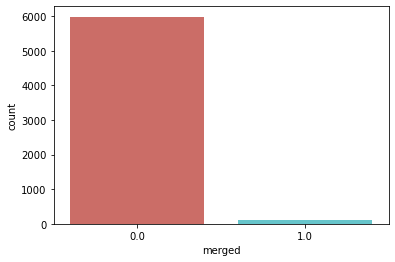

,id,merged,dsh1,dshpct,beds,bed_days,medicare_days,medicaid_days,days,employees,medicare_disch,medicaid_disch,discharges,overall,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,num_complete_survey,survey_response_rate,rate.x,mortality,safety,readmin,patient_exp,effective,timely,efficient_img,age,sex,buyin_mo,type_adm.x,type_adm.y,type_adm,ind_dsh,ind_teaching,efficiency,utilization,prop_discharges,rate.y,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,rate,hmo_rate,hhi,Hospital.Type_cat,Hospital.Ownership_cat,ownership_cat,state_cd_cat,state_cat,status_cat,city_cat,county_cat,rural_urban_cat
0,10001,0.0,8633626.0,0.1498,408.0,149328.0,42785.0,15986.0,87760,2160.600098,7790.0,3931.0,17435,70,83,74,54,61,69,67,63,83,75,5000,33,3.000000,2.000000,3.000000,1.666667,1.000000,2.000000,2.000000,2.000000,78.572954,0.454330,0.289442,0.654804,0.027284,0.317912,1,0,42.732843,0.589310,3009.226320,744.890000,3.0,102369.0,8.1,17.9,84.043998,0.000762,0.000723,0.003829,0.000068,0.000342,0.000049,0.000020,0.0,0.318573,0.298743,0.007356,0.006398,1.704217,1.412049,0.753724,744.890000,744.890000,3009.226320,0,1,2,1,1,0,754,708,1.0
1,10005,0.0,1724745.0,1.0000,108.0,39420.0,14303.0,1.0,24961,568.790000,2716.0,842.0,6482,1,1,1,1,1,1,1,1,1,1,1,1,2.666667,1.000000,2.000000,3.000000,2.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,0,60.018520,0.633207,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,1,2,1,1,2,289,943,1.0
2,10006,0.0,3498027.0,0.0951,358.0,130670.0,28599.0,7909.0,52665,968.530029,5039.0,1765.0,10862,55,84,76,57,61,67,64,60,78,57,5000,30,2.000000,1.000000,2.000000,1.666667,1.000000,2.000000,3.000000,1.666667,78.830645,0.427419,0.182258,0.627419,0.372581,0.000000,1,0,30.340782,0.403038,550.139739,739.490000,3.0,92781.0,8.3,17.6,81.355019,0.000496,0.000474,0.001918,0.000022,0.000216,0.000011,0.000011,0.0,0.123032,0.123032,0.002996,0.002996,0.551158,0.551158,0.297248,739.490000,739.490000,550.139739,0,1,2,1,1,2,938,859,1.0
3,10007,0.0,185865.0,0.0533,78.0,28548.0,4122.0,619.0,5867,153.450000,819.0,133.0,1302,60,84,76,63,55,69,66,67,66,58,5000,26,2.000000,1.666667,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,78.221150,0.375000,0.442308,0.740385,0.000000,0.259615,1,0,16.692310,0.206077,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,9,0,1,1,3,2070,380,1.0
4,10008,0.0,287870.0,0.1713,29.0,10614.0,1764.0,668.0,3240,106.699997,374.0,166.0,744,67,93,76,66,66,66,70,69,76,67,200,26,3.333333,2.000000,1.000000,2.333333,1.000000,2.000000,3.000000,1.000000,83.275862,0.275862,0.379310,0.482759,0.000000,0.517241,1,0,25.655172,0.306094,1852.171696,761.710000,8.0,13911.0,8.7,20.3,83.322550,0.000216,0.000216,0.000503,0.000000,0.000072,0.000144,0.000072,0.0,0.095823,0.075336,0.005248,0.003522,1.152325,0.697506,0.405147,761.710000,761.710000,1852.171696,0,5,1,1,1,0,1635,391,0.0
5,10009,0.0,175131.0,0.0641,130.0,47450.0,2148.0,293.0,3153,108.370003,572.0,104.0,967,1,1,1,1,1,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,81.647887,0.352113,0.394366,0.957746,0.000000,0.042254,1,0,7.438462,0.066449,544.804729,763.070007,3.0,119953.0,8.7,14.1,84.014572,0.000567,0.000534,0.001734,0.000033,0.000217,0.000033,0.000025,0.0,0.105491,0.101890,0.003776,0.003160,0.641718,0.443540,0.286687,763.070007,763.070007,544.804729,3,10,3,1,1,2,1190,1027,1.0
6,10010,0.0,1112826.0,0.0887,90.0,32850.0,10194.0,2185.0,18949,477.60

In [13]:
print(hosp_hcris.shape)
print(hosp_hcris.groupby('merged').size())
print(f"Class 1: {116/6103*100}%")
sn.countplot(x='merged', data=hosp_hcris, palette='hls')
plt.show()
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
hosp_hcris.head(20)

In [14]:
hosp_hcris.describe()

,id,merged,dsh1,dshpct,beds,bed_days,medicare_days,medicaid_days,days,employees,medicare_disch,medicaid_disch,discharges,overall,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,num_complete_survey,survey_response_rate,rate.x,mortality,safety,readmin,patient_exp,effective,timely,efficient_img,age,sex,buyin_mo,type_adm.x,type_adm.y,type_adm,ind_dsh,ind_teaching,efficiency,utilization,prop_discharges,rate.y,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,rate,hmo_rate,hhi,Hospital.Type_cat,Hospital.Ownership_cat,ownership_cat,state_cd_cat,state_cat,status_cat,city_cat,county_cat,rural_urban_cat
count,6103.000000,6103.000000,6.103000e+03,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6.103000e+03,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000,6103.000000
mean,268149.148452,0.019007,1.913052e+06,0.620141,131.624283,47343.832378,10113.048992,3753.683271,29421.753564,775.443946,1772.083074,751.550549,5611.965591,43.307881,50.819597,48.607734,41.222514,38.996887,44.052925,37.379485,45.413567,52.347698,44.223497,2412.427003,20.508111,2.272434,1.582118,1.471681,1.644109,1.594353,1.588345,1.627506,1.506199,74.919754,0.435012,0.266894,0.491324,0.270161,0.353198,0.460429,0.179092,33.144620,0.500343,1551.695443,770.340629,3.635425,6.424289e+05,8.151106,15.127757,76.916826,0.070139,0.070066,0.072102,0.069506,0.069753,0.069518,0.069511,0.069498,0.188120,0.179348,0.073290,0.072652,0.945291,0.763797,0.347150,724.774349,724.774349,1551.695443,1.166148,7.221367,1.205637,26.640832,26.640832,2.669343,1551.026708,875.122890,0.711945
std,156267.366618,0.136561,4.822727e+06,0.429593,160.088279,58864.184221,14260.065114,8716.758180,43922.823637,1587.651025,2601.193862,1571.521606,8618.916627,33.560261,38.868937,37.202483,32.002468,29.961953,33.684205,29.385449,34.967570,40.017884,34.413809,2475.187113,16.670783,1.218786,0.601256,0.682321,0.710934,0.784106,0.515096,0.760457,0.611411,19.000837,0.190194,0.256842,0.368445,0.359830,0.364475,0.498473,0.383461,19.909225,0.232827,1311.888162,231.742580,6.934419,1.497613e+06,3.179265,6.582502,21.843099,0.254098,0.254118,0.253573,0.254270,0.254203,0.254267,0.254269,0.254273,0.237445,0.237564,0.253265,0.253430,1.078389,0.784342,0.297814,271.068963,271.068963,1311.888162,1.299820,3.056818,1.246228,15.722920,15.722920,0.725155,899.655118,486.110108,0.452894
min,10001.000000,0.000000,1.000000e+00,0.019300,1.000000,74.000000,1.000000,1.000000,1.000000,0.060000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046948,0.000152,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0

In [15]:
hosp_hcris['ind_dsh'].value_counts()

0    3293
1    2810
Name: ind_dsh, dtype: int64

In [16]:
hosp_hcris['rural_urban_cat'].value_counts()

1.0    4345
0.0    1758
Name: rural_urban_cat, dtype: int64

Summary statistics for merged hospitals

In [17]:
hosp_hcris_merged = hosp_hcris.loc[hosp_hcris['merged'].isin([1])]
hosp_hcris_merged.describe()

,id,merged,dsh1,dshpct,beds,bed_days,medicare_days,medicaid_days,days,employees,medicare_disch,medicaid_disch,discharges,overall,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,num_complete_survey,survey_response_rate,rate.x,mortality,safety,readmin,patient_exp,effective,timely,efficient_img,age,sex,buyin_mo,type_adm.x,type_adm.y,type_adm,ind_dsh,ind_teaching,efficiency,utilization,prop_discharges,rate.y,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,rate,hmo_rate,hhi,Hospital.Type_cat,Hospital.Ownership_cat,ownership_cat,state_cd_cat,state_cat,status_cat,city_cat,county_cat,rural_urban_cat
count,116.000000,116.0,1.160000e+02,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.00000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.0,116.000000,116.000000,116.000000,116.000000,116.0,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,1.160000e+02,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,1.160000e+02,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.00000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,287284.275862,1.0,1.007895e+06,0.729251,99.017241,25330.637931,4742.267241,657.715517,11728.206897,414.21000,929.500000,425.706897,2750.206897,39.275862,47.655172,44.896552,38.818966,36.275862,40.913793,35.241379,41.362069,48.189655,40.267241,2222.405172,20.224138,1.022989,1.008621,1.0,1.008621,1.017241,1.008621,1.008621,1.0,76.375191,0.395220,0.300409,0.573689,0.212608,0.281846,0.637931,0.224138,27.119122,0.286967,1477.177706,779.404052,2.586207,9.038272e+05,8.682759,15.447414,78.490209,0.061003,0.060937,0.063135,0.060380,0.060670,0.060371,0.060366,6.034892e-02,0.178482,0.171085,0.063555,0.063040,0.818551,0.668188,0.326146,742.299828,742.299828,1477.177707,2.948276,9.87931,2.974138,28.637931,28.637931,2.672414,1532.112069,837.586207,0.810345
std,151561.805116,0.0,2.501383e+06,0.402826,86.643797,24589.696429,6228.417470,1758.800672,16890.256246,402.11325,1165.669701,892.983461,3727.363900,33.933845,40.316811,38.099042,33.638125,30.994975,34.769944,30.865943,35.319017,40.773588,34.876018,2471.742420,18.841714,0.247594,0.092848,0.0,0.092848,0.185695,0.092848,0.092848,0.0,14.654439,0.169841,0.245564,0.327750,0.312825,0.314647,0.482684,0.418823,21.184894,0.199206,1169.514080,234.919745,2.230496,1.786453e+06,2.966839,6.187652,19.975619,0.238990,0.239007,0.238458,0.239149,0.239075,0.239151,0.239152,2.391566e-01,0.219832,0.220159,0.238349,0.238477,0.569647,0.451908,0.245608,267.865259,267.865259,1169.514081,0.392203,0.95239,0.206890,15.426908,15.426908,0.731596,893.976712,501.227781,0.393729
min,10137.000000,1.0,1.000000e+00,0.031400,9.000000,600.000000,9.000000,1.000000,38.000000,33.26000,3.000000,1.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.203390,0.001765,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,0.000129,0.000000,0.000331,0.000000,0.000000,0.000004,0.000004,0.000000e+00,0.027144,0.027144,0.000525,0.000485,0.082385,0.082385,0.044548,1.000000,1.000000,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000,0.000000,26.000000,3.000000,0.000000
25%,165067.250000,1.0,1.000000e+00,0.161400,41.750000,10430.250000,133

In [18]:
hosp_hcris_merged['ind_dsh'].value_counts()

1    74
0    42
Name: ind_dsh, dtype: int64

In [19]:
hosp_hcris_merged['rural_urban_cat'].value_counts()

1.0    94
0.0    22
Name: rural_urban_cat, dtype: int64

In [20]:
hosp_hcris_merged['ownership_cat'].value_counts()

3    114
1      1
2      1
Name: ownership_cat, dtype: int64

In [21]:
hosp_hcris_merged['Hospital.Type_cat'].value_counts()

3    114
0      2
Name: Hospital.Type_cat, dtype: int64

In [22]:
hosp_hcris_merged['Hospital.Ownership_cat'].value_counts()

10    114
1       1
5       1
Name: Hospital.Ownership_cat, dtype: int64

Summary statistics for unmerged hospitals

In [23]:
hosp_hcris_unmerged = hosp_hcris.loc[hosp_hcris['merged'].isin([0])]
hosp_hcris_unmerged.describe()

,id,merged,dsh1,dshpct,beds,bed_days,medicare_days,medicaid_days,days,employees,medicare_disch,medicaid_disch,discharges,overall,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,num_complete_survey,survey_response_rate,rate.x,mortality,safety,readmin,patient_exp,effective,timely,efficient_img,age,sex,buyin_mo,type_adm.x,type_adm.y,type_adm,ind_dsh,ind_teaching,efficiency,utilization,prop_discharges,rate.y,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,rate,hmo_rate,hhi,Hospital.Type_cat,Hospital.Ownership_cat,ownership_cat,state_cd_cat,state_cat,status_cat,city_cat,county_cat,rural_urban_cat
count,5987.000000,5987.0,5.987000e+03,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.00000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5.987000e+03,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000
mean,267778.399365,0.0,1.930589e+06,0.618027,132.256055,47770.344914,10217.109571,3813.668615,29764.571572,782.442966,1788.408385,757.863872,5667.413062,43.386003,50.880909,48.679639,41.269083,39.049607,44.113746,37.420912,45.492066,52.428261,44.30015,2416.108736,20.513613,2.296643,1.593230,1.480820,1.656422,1.605534,1.599577,1.639497,1.516007,74.891554,0.435783,0.266245,0.489728,0.271276,0.354581,0.456990,0.178219,33.261365,0.504477,1553.139247,770.165023,3.655754,6.373642e+05,8.140805,15.121563,76.886341,0.070316,0.070242,0.072275,0.069683,0.069929,0.069695,0.069688,0.069675,0.188307,0.179508,0.073479,0.072838,0.947747,0.765650,0.347557,724.434787,724.434787,1553.139247,1.131619,7.169868,1.171371,26.602138,26.602138,2.669283,1551.393185,875.850175,0.710038
std,156346.296190,0.0,4.855206e+06,0.429853,161.120046,59253.269973,14351.828776,8786.667212,44214.646008,1601.186416,2618.625640,1581.177408,8677.360474,33.551062,38.841295,37.184498,31.971116,29.941820,33.662928,29.357194,34.959067,40.002301,34.40325,2475.315903,16.627649,1.217460,0.601541,0.685703,0.712094,0.787080,0.513479,0.762738,0.613193,19.075128,0.190497,0.257033,0.369032,0.360612,0.365258,0.498188,0.382729,19.867540,0.231511,1314.540052,231.696975,6.992903,1.491190e+06,3.182596,6.590252,21.878120,0.254397,0.254417,0.253873,0.254570,0.254503,0.254567,0.254569,0.254572,0.237787,0.237903,0.253561,0.253726,1.085775,0.789309,0.298738,271.141588,271.141588,1314.540052,1.287082,3.060757,1.233117,15.727360,15.727360,0.725091,899.835065,485.827052,0.453782
min,10001.000000,0.0,1.000000e+00,0.019300,1.000000,74.000000,1.000000,1.000000,1.000000,0.060000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046948,0.000152,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [24]:
hosp_hcris_unmerged['ind_dsh'].value_counts()

0    3251
1    2736
Name: ind_dsh, dtype: int64

In [25]:
hosp_hcris_unmerged['rural_urban_cat'].value_counts()

1.0    4251
0.0    1736
Name: rural_urban_cat, dtype: int64

In [26]:
hosp_hcris_unmerged['ownership_cat'].value_counts()

0    2756
3    1370
2    1042
1     819
Name: ownership_cat, dtype: int64

In [27]:
hosp_hcris_merged['Hospital.Type_cat'].value_counts()

3    114
0      2
Name: Hospital.Type_cat, dtype: int64

In [28]:
hosp_hcris_merged['Hospital.Ownership_cat'].value_counts()

10    114
1       1
5       1
Name: Hospital.Ownership_cat, dtype: int64